# App Entry Testing

The goal of this experiment is to collect frame statistics while swiping up and down tabs of recently opened applications on a Pixel device running Android with an EAS kernel. This process is name **Recents Fling**. The Analysis phase will consist in comparing EAS with other schedulers, that is comparing *sched* governor with:

    - interactive
    - performance
    - powersave
    - ondemand
    
For this experiment it is recommended to open many applications so that we can swipe over more recently opened applications.

In [1]:
import logging
from lisa.utils import setup_logging
setup_logging()

2019-08-20 23:09:04,880 INFO    : root         : Using LISA logging configuration:
2019-08-20 23:09:04,881 INFO    : root         :   /home/ubuntu/Android/lisa/logging.conf


In [2]:
import os
from lisa.target import Target, TargetConf

2019-08-20 23:09:04,892 INFO    : root         : Generating grammar tables from /usr/lib/python3.5/lib2to3/Grammar.txt
2019-08-20 23:09:04,911 INFO    : root         : Generating grammar tables from /usr/lib/python3.5/lib2to3/PatternGrammar.txt


In [3]:
import os
from time import sleep

# Support to access the remote target
import devlib

# Import support for Android devices
#from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual

#from android import System

import subprocess

## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [4]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in `my_target_conf`. Run `adb devices` on your host to get the ID.

In [5]:
adb_devices=!adb devices
adb_devices=adb_devices[1].split('\t')
print('adb device - {}'.format(adb_devices[0]))

adb device - R38KA07SR2J


In [6]:
LISA_HOME = !echo $LISA_HOME
LISA_HOME = LISA_HOME[0]
print(LISA_HOME)

/home/ubuntu/Android/lisa


In [7]:
target = Target(
    kind='android',
    device=adb_devices[0]
#    name='myhikey960',
#    host='192.168.0.1',
#    username='root',
#    password='root',
)

systrace_conf = {
    #"systrace" : {
        "events" : ["input", "view", "wm", "am", "sm", "audio", "video", "res", "dalvik", "rs", "bionic", "sched", "freq", "idle", "sync", "workq"],
        "buffsize" : 10240,
    #}
}

2019-08-20 23:09:07,244 INFO    : lisa.target.Target : Creating result directory: /home/ubuntu/Android/lisa/results/Target-<noname>-20190820_230907.243820
2019-08-20 23:09:07,245 INFO    : lisa.target.Target : android <noname> target connection settings:
2019-08-20 23:09:07,246 INFO    : lisa.target.Target :     device : R38KA07SR2J
2019-08-20 23:09:07,254 INFO    : lisa.target.Target : Devlib modules to load: bl, cgroups, cpufreq, cpuidle, devfreq, fastboot, gem5stats, gpufreq, hotplug, hwmon, mbed-fan, odroidxu3-fan, sched, thermal
2019-08-20 23:09:11,963 WARNING : AndroidTarget : Module gem5stats is not supported by the target
2019-08-20 23:09:14,739 WARNING : AndroidTarget : Module odroidxu3-fan is not supported by the target
2019-08-20 23:09:26,344 INFO    : CGroups      : Available controllers:
2019-08-20 23:09:27,268 INFO    : CGroups      :   cpuset       : /data/local/tmp/devlib-target/cgroups/devlib_cgh5
2019-08-20 23:09:28,097 INFO    : CGroups      :   cpu          : /data/

In [8]:
!adb root

!adb push $LISA_HOME/tools/aapt-arm-pie /data/local/tmp
!adb shell chmod 0755 /data/local/tmp/aapt-arm-pie


adbd is already running as root
/home/ubuntu/Android/lisa/tools/aapt-a...d. 27.8 MB/s (5182616 bytes in 0.178s)


## Defines

In [9]:
KEYCODE_HOME = 'KEYCODE_HOME'
KEYCODE_APP_SWITCH = 'KEYCODE_APP_SWITCH'
KEYCODE_DPAD_UP = 'KEYCODE_DPAD_UP'
KEYCODE_DPAD_DOWN = 'KEYCODE_DPAD_DOWN'
KEYCODE_DPAD_LEFT = 'KEYCODE_DPAD_LEFT'
KEYCODE_DPAD_RIGHT = 'KEYCODE_DPAD_RIGHT'
KEYCODE_DEL = 'KEYCODE_DEL'
KEY_DEL = 'DEL'

## Support Functions

This set of support functions will help us running the benchmark using different CPUFreq governors.

In [10]:
def open_apps(n):
    """
    Open `n` apps on the device
    
    :param n: number of apps to open
    :type n: int
    """
    # Get a list of third-party packages
    android_version = target.getprop('ro.build.version.release')
    if android_version >= 'N':
        packages = target.execute('cmd package list packages | cut -d: -f 2')
        packages = packages.splitlines()
    else:
        packages = target.execute('pm list packages -3 | cut -d: -f 2')
        packages = packages.splitlines()

    # As a safe fallback let's use a list of standard Android AOSP apps which are always available
    if len(packages) < 8:
        packages = [
            'com.android.messaging',
            'com.android.calendar',
            'com.android.settings',
            'com.android.calculator2',
            'com.android.email',
            'com.android.music',
            'com.android.deskclock',
            'com.android.contacts',
        ]
    
    LAUNCH_CMD = 'monkey -p {} -c android.intent.category.LAUNCHER 1 '
    
    if n > len(packages):
        n = len(packages)
        
    logging.info('Trying to open %d apps...', n)
    started = 0
    for app in packages:
        logging.debug('    Launching %s', app)
        try:
            target.execute(LAUNCH_CMD.format(app))
            started = started + 1
            logging.info('  %2d starting %s...', started, app)
        except Exception:
            pass
        if started >= n:
            break
        
    # Close Recents
    target.execute('input keyevent KEYCODE_HOME')


In [11]:
def recentsfling_run(exp_dir):
    # Unlock device screen (assume no password required)
    target.execute('input keyevent 82')

    # Configure screen to max brightness and no dimming
    Screen.set_brightness(target, percent=100)
    Screen.set_dim(target, auto=False)
    Screen.set_timeout(target, 60*60*10) # 10 hours should be enought for an experiment

    # Open Recents on the target device
    target.execute('input keyevent KEYCODE_APP_SWITCH')
    # Allow the activity to start
    sleep(5)
    # Reset framestats collection
    target.execute('dumpsys gfxinfo --reset')
    
    w, h = target.screen_resolution
    x = w/2
    yl = int(0.2*h)
    yh = int(0.9*h)
    
    logging.info('Start Swiping Recents')
    for i in range(5):
        # Simulate two fast UP and DOWN swipes
        target.execute('input swipe {} {} {} {} 50'.format(x, yl, x, yh))
        sleep(0.3)
        target.execute('input swipe {} {} {} {} 50'.format(x, yh, x, yl))
        sleep(0.7)
    logging.info('Swiping Recents Completed')
    
    # Reset screen brightness and auto dimming
    Screen.set_defaults(target)

    # Get frame stats
    framestats_file = os.path.join(exp_dir, "framestats.txt")
    adb_command(target.adb_name, 'shell dumpsys gfxinfo com.android.systemui > {}'.format(framestats_file))
    
    # Close Recents
    target.execute('input keyevent KEYCODE_HOME')

    return framestats_file

In [12]:
def experiment(governor, exp_dir):
    os.system('mkdir -p {}'.format(exp_dir));

    logging.info('------------------------')
    logging.info('Run workload using %s governor', governor)
    confs[governor]['set']()
    
    # Start FTrace
    te.ftrace.start()
      
    ### Run the benchmark ###
    framestats_file = recentsfling_run(exp_dir)
    
    # Stop FTrace
    te.ftrace.stop()    

    # Collect and keep track of the trace
    trace_file = os.path.join(exp_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)
    
    # Parse trace
    tr = Trace(exp_dir,
               my_conf['ftrace']['events'],
               te.platform)
    
    # return all the experiment data
    return {
        'dir'             : exp_dir,
        'framestats_file' : framestats_file,
        'trace_file'      : trace_file,
        'ftrace'          : tr.ftrace,
        'trace'           : tr
    }

In [13]:
def get_apk_list(chboxes, path):
    directories = list()
    #current_path = my_conf["LISA_HOME"] + '/apks' + path
    current_path = LISA_HOME + '/apks' + path
    
    try:
        os.listdir(current_path)
    except:
        return
    
    for apk in os.listdir(current_path):
        if not '.apk' in apk :
            directories.append(apk)
            continue
            
        application_name = ['None', 'None']
        grep = "application-label-en"
        while len(grep) > len("application"):
            try:
                application_name = subprocess.check_output("/home/ubuntu/Android/AndroidSDK/build-tools/25.0.2/aapt dump badging {} | grep {}".format(current_path + '/' + apk, grep), shell=True).splitlines()[0].split("'")
                break
            except:
                for idx in range(len(grep) + 1):
                    if grep[-idx] == '-':
                        break;
                grep = grep[0:-idx]
                #print(grep)
           
        package_name = subprocess.check_output("/home/ubuntu/Android/AndroidSDK/build-tools/25.0.2/aapt dump badging {} | grep {}".format(current_path + '/' + apk, 'package:'), shell=True).splitlines()[0].split("'")[1]

        
        if len(application_name) > 1:
            descript = "{} - {}/{} - {}".format(application_name[1], path, apk, package_name)
            #print(apk + " / " + application_name)
            chboxes.append(widgets.Checkbox(
                value=False,
                description=descript,#.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
            ))
            
    for directory in directories:
        get_apk_list(chboxes, path + '/' + directory)

In [14]:
def get_app_list():
    # Get a list of third-party packages
    CMD_PACKAGE_LIST = ""
    android_version = target.getprop('ro.build.version.release')
    if android_version >= 'N':
        CMD_PACKAGE_LIST = 'cmd package list packages | grep {} | cut -d: -f 2'
    else:
        CMD_PACKAGE_LIST = 'pm list packages -f | grep {} | cut -d: -f 2'
    CMD_LAUNCHER_DB = "sqlite3 /data/data/com.sec.android.app.launcher/databases/launcher.db -cmd 'select componentName from appsTray' .exit"
 
    launcher_db = target.execute(CMD_LAUNCHER_DB).splitlines()
    
    print('----------------- launcher_db -----------------')
    display(launcher_db)
    print('-----------------------------------------------')
        
    packages = list()
    for component in launcher_db:
        if len(component) > 0 and '/' in component :
            component = component.split('/')[0]
            component = target.execute(CMD_PACKAGE_LIST.format(component)).splitlines()[0]
            packages.append(component)
            #print(component + " - " + packages)

    print('------------------ packages -------------------')
    display(packages)
    print('-----------------------------------------------')
    #print(len(packages))
    #print('-----------------------------------------------') 
    
    chboxes = dict()
    chboxes[0] = list()
    chboxes[1] = list()
    chboxes[2] = list()
        
    for i in range(len(packages)) :
        file_package = packages[i].split(".apk=")
        application_data = target.execute('/data/local/tmp/aapt-arm-pie d badging {} | grep application:'.format(file_package[0] + ".apk")).split(" ")
        
        for application_name in application_data :
            if 'label=' in application_name :
                application_name = application_name.split("'")[1]
                break
                
        print(application_name)
        
        if len(file_package) == 2 and len(application_name) > 1:
            #print(application_name[1])
            descript = "{} - {}".format(application_name[1], file_package[1])

            #print(descript)
            chboxes[int(2 * i / len(packages))].append(widgets.Checkbox(
                value=False,
                description=descript,#.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
            ))
    
    get_apk_list(chboxes[2], '')
    
    return chboxes
#get_app_list()

In [15]:
def adb_press(keycode):
    target.execute('input keyevent ' + keycode)

In [16]:
def get_pid(package):
    try:
        return subprocess.check_output("adb shell ps -o PID -o NAME | grep {}".format(package), shell=True).splitlines()[0].split(' ')[0]
    except:
        return 0
    return 

In [17]:
def on_click_start(change):
    count = 0
    packages = list()
    
    wakeup()
    print('\n\n===== Testing list =====\n')
    
    for chbox in chboxes :
        for item in chboxes[chbox] :
            if(item.value) :
                count += 1
                package = item.description.split(' - ')
                print(str(count) + ' - ' + item.description)
                if '.apk' in package[1] and len(package) > 2:
                    packages.append({'application' : package[0], 'apk' : package[1], 'package' : package[2]})
                    install_cmd = 'adb install ' + my_conf["LISA_HOME"] + '/apks' + package[1];
                    try:
                        print('        -> ' + install_cmd)
                        os.system(install_cmd)
                    except:
                        print('        -> failed to install')
                else:
                    packages.append({'application' : package[0], 'package' : package[1]})
          
    if count == 0 :
        print('There is no testing app in the list.\nPlease select over apps')
        return

    print('\n\n===== Testing =====\n')
    
    exp_dir = 'testingdata'
    os.system('mkdir -p {}'.format(exp_dir))
    
    CMD_LAUNCH = 'monkey -p {} -c android.intent.category.LAUNCHER 1 '   
    CMD_GET_RECENT_APPS = "dumpsys activity recents | grep 'Recent #'"
    CMD_FORCE_STOP =  "adb shell am force-stop {}"

    adb_press(KEYCODE_HOME)
    
    for app in packages:
        adb_press(KEYCODE_APP_SWITCH)
        sleep(1)
        
        Directions = [KEYCODE_DPAD_UP, KEYCODE_DPAD_DOWN, KEYCODE_DPAD_LEFT, KEYCODE_DPAD_RIGHT]

        for Direction in Directions:
            completed = False
            
            for i in range(5):
                count = 0
                nbRecentApps = len(target.execute(CMD_GET_RECENT_APPS).split('\n'))
                nbPreRecentApps = nbRecentApps + 1
                
                while nbRecentApps < nbPreRecentApps:
                    adb_press(KEYCODE_DEL)
                    adb_press(KEY_DEL)
                    nbPreRecentApps = nbRecentApps
                    nbRecentApps = len(target.execute(CMD_GET_RECENT_APPS).split('\n'))
                    count += 1
                    
                if count > 1 :
                    completed = True
                    break;

                #print(CMD_PRESS + Direction)
                adb_press(Direction)
                sleep(1)
                
            if completed :
                break;

        #te.ftrace.start() # Start FTrace
        systrace_output = System.systrace_start(te, os.path.join(exp_dir, 'trace.html'), 
                                                time=10, conf=systrace_conf)
        systrace_output.expect("Starting tracing")
 
        sleep(1)
    
        try:
            print('     Try Launching... ' + app['application'] + '   -   ' + app['package'])
            print(CMD_LAUNCH.format(app['package']))
            target.execute(CMD_LAUNCH.format(app['package']))
            sleep(3)
        except Exception:
            pass
        #te.ftrace.stop()   # Stop FTrace 
        
        systrace_output.sendline("")
        System.systrace_wait(te, systrace_output)
        te.platform_dump(te.res_dir)
        
        # Collect and keep track of the trace
        #trace_file = os.path.join(exp_dir, 'trace.dat')
        #te.ftrace.get_trace(trace_file)

        # Parse trace
        #tr = Trace(exp_dir, my_conf['ftrace']['events'], te.platform)
        
        print(get_pid(app['package']))
        
        try:
            target.execute(CMD_FORCE_STOP.format(app['package']))
            sleep(1)
        except Exception:
            pass
        

In [18]:
def wakeup():
    CMD_TOP_ACTIVITY = "dumpsys activity | grep top-activity"
    CMD_UNLOCK = "input keyevent 82 && input keyevent 66"
    CMD_POWER = "input keyevent KEYCODE_POWER"
    
    flag = False
    
    try:
        checking = (len(target.execute(CMD_TOP_ACTIVITY)) == 0)
    except:
        checking = True
        
    while checking:
        if(flag):
            flag = False
            target.execute(CMD_POWER)
        else:
            flag = True
        target.execute(CMD_UNLOCK)
        
        sleep(1)
        
        try:
            checking = (len(target.execute(CMD_TOP_ACTIVITY)) == 0)
        except:
            checking = True

## Precondition

In [19]:
chboxes = get_app_list()

----------------- launcher_db -----------------


['',
 'com.google.android.googlequicksearchbox/.SearchActivity',
 'com.android.chrome/com.google.android.apps.chrome.Main',
 'com.google.android.gm/.ConversationListActivityGmail',
 'com.google.android.apps.maps/com.google.android.maps.MapsActivity',
 'com.google.android.youtube/.app.honeycomb.Shell$HomeActivity',
 'com.google.android.apps.docs/.app.NewMainProxyActivity',
 'com.google.android.videos/com.google.android.youtube.videos.EntryPoint',
 'com.google.android.apps.tachyon/.MainActivity',
 'com.google.android.apps.photos/.home.HomeActivity',
 '',
 'com.yahoo.mobile.client.android.finance/.activity.Main',
 'com.oath.flamingo/.main.MainActivity',
 'com.yahoo.mobile.client.android.sportacular/com.yahoo.mobile.ysports.activity.LauncherActivity',
 'com.yahoo.mobile.client.android.yahoo/com.yahoo.homerun.streams.presentation.view.activity.MainNavigationActivity',
 '',
 'com.sec.android.app.myfiles/.external.ui.MainActivity',
 'com.sec.android.app.shealth/com.samsung.android.app.shealth

-----------------------------------------------
------------------ packages -------------------


['/system/priv-app/Velvet/Velvet.apk=com.google.android.googlequicksearchbox',
 '/system/app/Chrome/Chrome.apk=com.android.chrome',
 '/system/app/Gmail2/Gmail2.apk=com.google.android.gm',
 '/system/app/Maps/Maps.apk=com.google.android.apps.maps',
 '/system/app/YouTube/YouTube.apk=com.google.android.youtube',
 '/data/app/Drive/Drive.apk=com.google.android.apps.docs',
 '/data/app/Videos/Videos.apk=com.google.android.videos',
 '/data/app/Duo/Duo.apk=com.google.android.apps.tachyon',
 '/data/app/Photos/Photos.apk=com.google.android.apps.photos',
 '/data/app/YahooFinance/YahooFinance.apk=com.yahoo.mobile.client.android.finance',
 '/data/app/YahooPlay/YahooPlay.apk=com.oath.flamingo',
 '/data/app/YahooSports/YahooSports.apk=com.yahoo.mobile.client.android.sportacular',
 '/data/app/YahooNews/YahooNews.apk=com.yahoo.mobile.client.android.yahoo',
 '/system/priv-app/SecMyFiles2019/SecMyFiles2019.apk=com.sec.android.app.myfiles',
 '/data/app/SHealth6/SHealth6.apk=com.sec.android.app.shealth',
 '/

-----------------------------------------------
Google
Chrome
Gmail
Maps
YouTube
Drive
Google
Duo
Photos
Finance
Play
Sports
Yahoo
My
Samsung
Smart​Things
Caller
Cloud
hum
Message+
My
Security
Calculator
Calendar
Camera
Clock
Contacts
Email
Galaxy
Galaxy
Gallery
Game
Google
Samsung
Messages
Phone
Google
Google
Samsung
Settings
Spotify
Voicemail
EpdgTestApp
Samsung
Dev
QSensorTest
SSMEditor
Unified
IMS
Radio
IOTHiddenMenu


## UI Performance Analysis

In [36]:
#button = widgets.Button(
#    description='START',
#    disabled=False,
#    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#    tooltip='Click me to start',
#)

toggle = widgets.ToggleButton(
    description='START'
)
#, layout=widgets.Layout(overflow_y='auto')    

widgets.VBox([
        widgets.HBox([ widgets.VBox(chboxes[0]), widgets.VBox(chboxes[1]), widgets.VBox(chboxes[2]) ]),
        toggle
])


toggle.observe(on_click_start, 'value')

In [37]:
import ipywidgets

ipywidgets.IntSlider()

IntSlider(value=0)

Button(description='save', style=ButtonStyle())

Output()

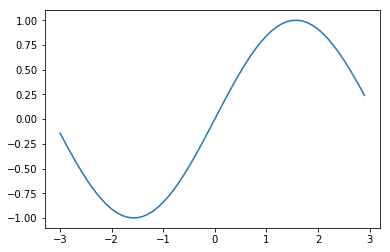

In [38]:
button = widgets.Button(description='save')
display(button)

output = widgets.Output()
display(output)

import numpy as np
import matplotlib.pyplot as plt
x = np.arange(-3, 3, 0.1)
y = np.sin(x)
plt.plot(x, y)


### Run workload and collect traces

In [22]:
# Unlock device screen (assume no password required)
#target.execute('input keyevent 82')

# Run the benchmark in all the configured governors
#for governor in confs:
#    test_dir = os.path.join(te.res_dir, governor)
#    results[governor] = experiment(governor, test_dir)

## UI Performance Analysis

In [23]:
#for governor in confs:
#    framestats_file = results[governor]['framestats_file']
#    print "Frame Statistics for {} governor".format(governor.upper())
#    !sed '/Stats since/,/99th/!d;/99th/q' $framestats_file
#    print ""